In [1]:
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm
import numpy as np

from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import EMNIST
import torchvision
import torch

import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Dataset

In [3]:
random_seed = 42
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)

In [4]:
transform = torchvision.transforms.Compose([
    lambda img: torchvision.transforms.functional.rotate(img, -90),
    lambda img: torchvision.transforms.functional.hflip(img),
    torchvision.transforms.ToTensor()
])

train_data = EMNIST(
    root='data',
    split='letters',
    train=True,
    download=True,
    transform=transform
)
test_data = EMNIST(
    root='data',
    split='letters',
    train=False,
    download=True,
    transform=transform
)

In [5]:
print(len(train_data))
print(len(test_data))
print(train_data.classes)
n_classes = len(train_data.classes)
print(f"Amount of classes: {n_classes}")
print(f"Image size: [C,W,H] = {train_data[0][0].size()}")

124800
20800
['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Amount of classes: 27
Image size: [C,W,H] = torch.Size([1, 28, 28])


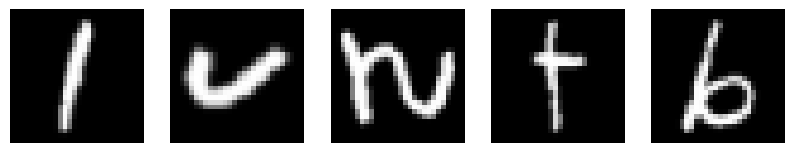

['l', 'u', 'n', 't', 'b']


In [6]:
figure = plt.figure(figsize=(10, 2))

N = 5
labels = []
for i in range(1, N+1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    labels.append(train_data.classes[label])
    figure.add_subplot(1, N, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.axis("off")
plt.show()
print(labels)


### Код для обучения

Взят из семинаров

In [7]:
def train_on_batch(model,
                   x_batch,
                   y_batch,
                   optimizer,
                   loss_function):
    
    model.train()
    model.zero_grad()

    output = model(x_batch.to(device))

    loss = loss_function(output, y_batch.to(device))
    loss.backward()

    optimizer.step()
    return loss.cpu().item()

In [8]:
def train_epoch(train_generator,
                model,
                loss_function,
                optimizer,
                callback=None):
    
    epoch_loss = 0
    total = 0

    for it, (batch_of_x, batch_of_y) in enumerate(train_generator):
        batch_loss = train_on_batch(model, batch_of_x.to(device), batch_of_y.to(device), optimizer, loss_function)

        if callback is not None:
            callback(model, batch_loss)

        epoch_loss += batch_loss * len(batch_of_x)
        total += len(batch_of_x)

    return epoch_loss / total

In [9]:
def trainer(count_of_epoch,
            batch_size,
            dataset,
            model,
            loss_function,
            optimizer,
            lr=0.001,
            callback=None):

    optima = optimizer(model.parameters(), lr=lr)

    iterations = range(count_of_epoch)
    for it in iterations:
        batch_generator = torch.utils.data.DataLoader(dataset=dataset,
                                                      batch_size=batch_size,
                                                      shuffle=True)

        epoch_loss = train_epoch(
            train_generator=batch_generator,
            model=model,
            loss_function=loss_function,
            optimizer=optima,
            callback=callback
        )

In [10]:
def quality_of_train(batch_size,
                     dataset,
                     model,
                     loss_function):

    batch_generator = torch.utils.data.DataLoader(dataset=dataset,
                                                  batch_size=batch_size)

    pred = []
    real = []
    test_loss = 0

    for it, (x_batch, y_batch) in enumerate(batch_generator):
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        output = model(x_batch)

        test_loss += loss_function(output, y_batch).cpu().item() * len(x_batch)

        pred.extend(torch.argmax(output, dim=-1).cpu().numpy().tolist())
        real.extend(y_batch.cpu().numpy().tolist())

    test_loss /= len(dataset)

    return test_loss, pred, real

### CNN model

In [11]:
class CNN(torch.nn.Module):
    @property
    def device(self):
        for p in self.parameters():
            return p.device

    def __init__(self, n_layers=1, kernel_size=5, pooling=False, batch_norm=False, dropout=0.0):
        super().__init__()

        # Number of channels in input pictures (black&white picture => 1 channel).
        self.n_channels = 1
        self.layers = torch.nn.Sequential()

        for layer in range(n_layers):
            # Convolution with n_channels*4 filters/kernels of size (n_channels, kernel_size, kernel_size)
            self.layers.add_module('conv' + str(layer),
                torch.nn.Conv2d(self.n_channels, self.n_channels * 4,
                                kernel_size=kernel_size, padding=(kernel_size - 1) // 2))
            self.n_channels *= 4

            # Batch normalization
            if batch_norm:
                self.layers.add_module('bn' + str(layer), torch.nn.BatchNorm2d(self.n_channels))

            self.layers.add_module('relu' + str(layer), torch.nn.ReLU())

            if pooling:
                # Pooling with kernel_size = stride
                self.layers.add_module('pool' + str(layer), torch.nn.MaxPool2d(kernel_size=2))

        self.layers.add_module('flatten', torch.nn.Flatten(start_dim=1))
        self.layers.add_module('dropout', torch.nn.Dropout(dropout))
        # Use LazyLinear to automatically infer amount of in_features
        self.layers.add_module('linear', torch.nn.LazyLinear(n_classes))

        # Do not use softmax, because we use CrossEntropyLoss, which uses softmax internally.
        # See: https://discuss.pytorch.org/t/pytorch-torch-nn-equivalent-of-tensorflow-keras-dense-layers/133518/6

    def forward(self, input):
        return self.layers(input)

### Tensorboard callback

In [12]:
class tensorboard_callback():
    def __init__(self, writer, dataset, loss_function, batch_size, delimeter):
        self.step = 0
        self.writer = writer
        self.delimeter = delimeter
        self.loss_function = loss_function
        self.batch_size = batch_size

        self.dataset = dataset

    def forward(self, model, loss):
        self.step += 1
        self.writer.add_scalar('LOSS/train', loss, self.step)

        if self.step % self.delimeter == 0:
            self.writer.add_graph(model, self.dataset[0][0].view(1, 1, 28, 28).to(model.device))

            test_loss, pred, real = quality_of_train(batch_size=self.batch_size, dataset=self.dataset,
                                                     model=model, loss_function=self.loss_function)
            self.writer.add_scalar('LOSS/test', test_loss, self.step)
            self.writer.add_scalar('ACCURACY/test',
                                   1 - np.count_nonzero(np.array(pred) - np.array(real)) / len(self.dataset),
                                   self.step)

    def __call__(self, model, loss):
        return self.forward(model, loss)

### Code for CNN training

In [13]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam
batch_size = 128

In [15]:
grid = ParameterGrid({
    'n_layers': [2, 3],
    'kernel_size': [3, 5],
    'pooling': [False, True],
    'batch_norm': [False, True],
    'dropout': [0.0, 0.3],
})

for params in tqdm(grid):
    print(str(params))

    # Create model
    model = CNN(**params)
    mod = model.to(device)
    
    writer = SummaryWriter(f'experiments/{str(params)}')
    callback = tensorboard_callback(writer, test_data, loss_function, batch_size=batch_size, delimeter=300)

    trainer(count_of_epoch=3,
            batch_size=batch_size,
            dataset=train_data,
            model=model,
            loss_function=loss_function,
            optimizer=optimizer,
            lr=0.001,
            callback=callback)


  0%|                                                                                                                                                  | 0/32 [00:00<?, ?it/s]

{'batch_norm': False, 'dropout': 0.0, 'kernel_size': 3, 'n_layers': 2, 'pooling': False}


  3%|████▎                                                                                                                                     | 1/32 [00:48<25:18, 48.97s/it]

{'batch_norm': False, 'dropout': 0.0, 'kernel_size': 3, 'n_layers': 2, 'pooling': True}


  6%|████████▋                                                                                                                                 | 2/32 [01:37<24:20, 48.69s/it]

{'batch_norm': False, 'dropout': 0.0, 'kernel_size': 3, 'n_layers': 3, 'pooling': False}


  9%|████████████▉                                                                                                                             | 3/32 [02:38<26:17, 54.40s/it]

{'batch_norm': False, 'dropout': 0.0, 'kernel_size': 3, 'n_layers': 3, 'pooling': True}


 12%|█████████████████▎                                                                                                                        | 4/32 [03:28<24:30, 52.52s/it]

{'batch_norm': False, 'dropout': 0.0, 'kernel_size': 5, 'n_layers': 2, 'pooling': False}


 16%|█████████████████████▌                                                                                                                    | 5/32 [04:19<23:27, 52.12s/it]

{'batch_norm': False, 'dropout': 0.0, 'kernel_size': 5, 'n_layers': 2, 'pooling': True}


 19%|█████████████████████████▉                                                                                                                | 6/32 [05:07<21:57, 50.66s/it]

{'batch_norm': False, 'dropout': 0.0, 'kernel_size': 5, 'n_layers': 3, 'pooling': False}


 22%|██████████████████████████████▏                                                                                                           | 7/32 [06:20<24:04, 57.79s/it]

{'batch_norm': False, 'dropout': 0.0, 'kernel_size': 5, 'n_layers': 3, 'pooling': True}


 25%|██████████████████████████████████▌                                                                                                       | 8/32 [07:11<22:16, 55.69s/it]

{'batch_norm': False, 'dropout': 0.3, 'kernel_size': 3, 'n_layers': 2, 'pooling': False}


 28%|██████████████████████████████████████▊                                                                                                   | 9/32 [08:01<20:43, 54.06s/it]

{'batch_norm': False, 'dropout': 0.3, 'kernel_size': 3, 'n_layers': 2, 'pooling': True}


 31%|██████████████████████████████████████████▊                                                                                              | 10/32 [08:52<19:29, 53.14s/it]

{'batch_norm': False, 'dropout': 0.3, 'kernel_size': 3, 'n_layers': 3, 'pooling': False}


 34%|███████████████████████████████████████████████                                                                                          | 11/32 [09:58<19:58, 57.05s/it]

{'batch_norm': False, 'dropout': 0.3, 'kernel_size': 3, 'n_layers': 3, 'pooling': True}


 38%|███████████████████████████████████████████████████▍                                                                                     | 12/32 [10:52<18:39, 55.96s/it]

{'batch_norm': False, 'dropout': 0.3, 'kernel_size': 5, 'n_layers': 2, 'pooling': False}


 41%|███████████████████████████████████████████████████████▋                                                                                 | 13/32 [11:46<17:34, 55.50s/it]

{'batch_norm': False, 'dropout': 0.3, 'kernel_size': 5, 'n_layers': 2, 'pooling': True}


 44%|███████████████████████████████████████████████████████████▉                                                                             | 14/32 [12:38<16:20, 54.44s/it]

{'batch_norm': False, 'dropout': 0.3, 'kernel_size': 5, 'n_layers': 3, 'pooling': False}


 47%|████████████████████████████████████████████████████████████████▏                                                                        | 15/32 [13:56<17:26, 61.53s/it]

{'batch_norm': False, 'dropout': 0.3, 'kernel_size': 5, 'n_layers': 3, 'pooling': True}


 50%|████████████████████████████████████████████████████████████████████▌                                                                    | 16/32 [14:50<15:50, 59.40s/it]

{'batch_norm': True, 'dropout': 0.0, 'kernel_size': 3, 'n_layers': 2, 'pooling': False}


 53%|████████████████████████████████████████████████████████████████████████▊                                                                | 17/32 [15:43<14:20, 57.34s/it]

{'batch_norm': True, 'dropout': 0.0, 'kernel_size': 3, 'n_layers': 2, 'pooling': True}


 56%|█████████████████████████████████████████████████████████████████████████████                                                            | 18/32 [16:36<13:03, 55.98s/it]

{'batch_norm': True, 'dropout': 0.0, 'kernel_size': 3, 'n_layers': 3, 'pooling': False}


 59%|█████████████████████████████████████████████████████████████████████████████████▎                                                       | 19/32 [17:44<12:56, 59.70s/it]

{'batch_norm': True, 'dropout': 0.0, 'kernel_size': 3, 'n_layers': 3, 'pooling': True}


 62%|█████████████████████████████████████████████████████████████████████████████████████▋                                                   | 20/32 [18:39<11:40, 58.36s/it]

{'batch_norm': True, 'dropout': 0.0, 'kernel_size': 5, 'n_layers': 2, 'pooling': False}


 66%|█████████████████████████████████████████████████████████████████████████████████████████▉                                               | 21/32 [19:35<10:34, 57.66s/it]

{'batch_norm': True, 'dropout': 0.0, 'kernel_size': 5, 'n_layers': 2, 'pooling': True}


 69%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 22/32 [20:29<09:23, 56.31s/it]

{'batch_norm': True, 'dropout': 0.0, 'kernel_size': 5, 'n_layers': 3, 'pooling': False}


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 23/32 [21:51<09:36, 64.00s/it]

{'batch_norm': True, 'dropout': 0.0, 'kernel_size': 5, 'n_layers': 3, 'pooling': True}


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 24/32 [22:47<08:14, 61.83s/it]

{'batch_norm': True, 'dropout': 0.3, 'kernel_size': 3, 'n_layers': 2, 'pooling': False}


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 25/32 [23:42<06:57, 59.59s/it]

{'batch_norm': True, 'dropout': 0.3, 'kernel_size': 3, 'n_layers': 2, 'pooling': True}


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 26/32 [24:35<05:46, 57.83s/it]

{'batch_norm': True, 'dropout': 0.3, 'kernel_size': 3, 'n_layers': 3, 'pooling': False}


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 27/32 [25:45<05:06, 61.35s/it]

{'batch_norm': True, 'dropout': 0.3, 'kernel_size': 3, 'n_layers': 3, 'pooling': True}


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 28/32 [26:41<03:58, 59.74s/it]

{'batch_norm': True, 'dropout': 0.3, 'kernel_size': 5, 'n_layers': 2, 'pooling': False}


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 29/32 [27:38<02:56, 58.97s/it]

{'batch_norm': True, 'dropout': 0.3, 'kernel_size': 5, 'n_layers': 2, 'pooling': True}


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 30/32 [28:31<01:54, 57.10s/it]

{'batch_norm': True, 'dropout': 0.3, 'kernel_size': 5, 'n_layers': 3, 'pooling': False}


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 31/32 [29:54<01:04, 64.93s/it]

{'batch_norm': True, 'dropout': 0.3, 'kernel_size': 5, 'n_layers': 3, 'pooling': True}


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [30:51<00:00, 57.85s/it]


### Conclusions

Реализована модель CNN, проведен grid-search по гиперпараметрам, выполнена оценка loss и accuracy.

Результаты:
- Модели с 3 слоями лучше, чем с двумя, при фиксации остальных параметров.
- Pooling ухудшает качество модели
- Batch norm ухудшает качество модели
- Dropout ухудшает качество модели
- Небольшая разница в качестве между train/test

Все результаты говорят о том, что модели не хватает гибкости. Можно попробовать увеличить количество слоев, размер kernel-a.

P.S. Обучение занимает значительный период времени (порядка 40-60 секунд для каждой конфигурации гиперпараметров на consumer-grade PC). Значительный overhead дает расчет loss/accuracy на test_data для tensorboard-a, поэтому параметр delimeter (раз во сколько batch-ей производится расчет) был поднят с 10 до 300.